In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
model = pybamm.lithium_sulfur.HuaEtAl2019()

# we want to recreate figure 4
# However, there doesn't appear to be a specified initial condition for charging
# Therefore, we are going to discharge at the same current as charge
current = 1.0
hours = 10.5
time_in_seconds = hours*3600
# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
params = model.default_parameter_values
m_s = params['Mass of active sulfur per cell [g]']
Hua_mass = 8.1
mass_ratio = Hua_mass/m_s
S8_discharge_initial = params["Initial Condition for S8 ion [g]"] * mass_ratio
S4_discharge_initial = params["Initial Condition for S4 ion [g]"] * mass_ratio
S2_discharge_initial = params["Initial Condition for S2 ion [g]"] * mass_ratio
S_discharge_initial = params["Initial Condition for S ion [g]"] * mass_ratio
Sp_discharge_initial = params["Initial Condition for Precipitated Sulfur [g]"] * mass_ratio

params.update(
    {
        "Current function [A]": current,
        "Mass of active sulfur per cell [g]": Hua_mass,
        "Initial Condition for S8 ion [g]":  S8_discharge_initial,
        "Initial Condition for S4 ion [g]": S4_discharge_initial,
        "Initial Condition for S2 ion [g]": S2_discharge_initial,
        "Initial Condition for S ion [g]": S_discharge_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_discharge_initial,
        "Standard Potential L [V]": 2.195,
        "Exchange current density H [A.m-2]": 1,
        "Exchange current density L [A.m-2]": 0.5,
        "S saturation mass [g]": 5e-5,
        "Shuttle rate coefficient during charge [s-1]": 2.75e-5
    }
)


In [3]:
# Check the capacity of the cell is 10 Ah

Ms = 32
F = model.param.F.value
ne = 4
nS8 = 8
nS4 = 4

capacity = F*ne*((3*S8_discharge_initial/nS8)+(S4_discharge_initial/nS4))/(3600*Ms)
capacity

10.162619122201876

In [4]:
# Set up and solve simulation
sim_d = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15
    ),
)
sim_d.solve(np.linspace(0, time_in_seconds, 10000))
voltage = sim_d.solution['Terminal voltage [V]'].entries

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

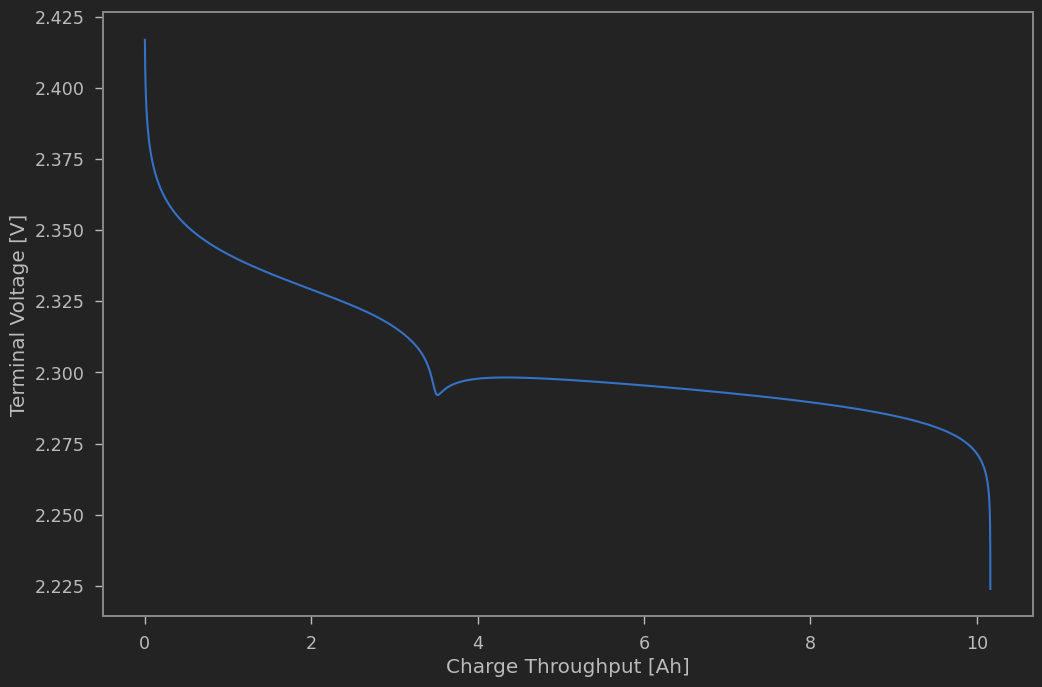

In [5]:
plt.plot(abs(current)*sim_d.solution.t/3600, voltage)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

In [6]:
ref = -10
S8_initial_charge = sim_d.solution["S8 [g]"].entries[ref]
S4_initial_charge = sim_d.solution["S4 [g]"].entries[ref]
S2_initial_charge = sim_d.solution["S2 [g]"].entries[ref]
S_initial_charge = sim_d.solution["S [g]"].entries[ref]
Sp_initial_charge = sim_d.solution["Precipitated Sulfur [g]"].entries[ref]
V_initial_charge = sim_d.solution["Terminal voltage [V]"].entries[ref]

In [8]:
model = pybamm.lithium_sulfur.HuaEtAl2019()
current = -1.0
ref_temp = 298
hours = 12
time_in_seconds = hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_charge,
        "Initial Condition for S4 ion [g]": S4_initial_charge,
        "Initial Condition for S2 ion [g]": S2_initial_charge,
        "Initial Condition for S ion [g]": S_initial_charge,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_charge,
        "Initial Condition for Shuttled Sulfur [g]": 0.0,
        "Initial Condition for Terminal Voltage [V]": V_initial_charge,
        "Mass of active sulfur per cell [g]": 8.1,
        "Standard Potential L [V]": 2.195,
        "Exchange current density H [A.m-2]": 1,
        "Exchange current density L [A.m-2]": 0.5,
        "S saturation mass [g]": 5e-5,
        "Shuttle rate coefficient during charge [s-1]": 2.75e-5,
        "Reference Temperature [K]" : ref_temp
    }
)

# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15
    ),
)
sim.solve(np.linspace(0, time_in_seconds, 100000))
voltage = sim.solution['Terminal voltage [V]'].entries

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 41707.4 and h = 4.78283e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

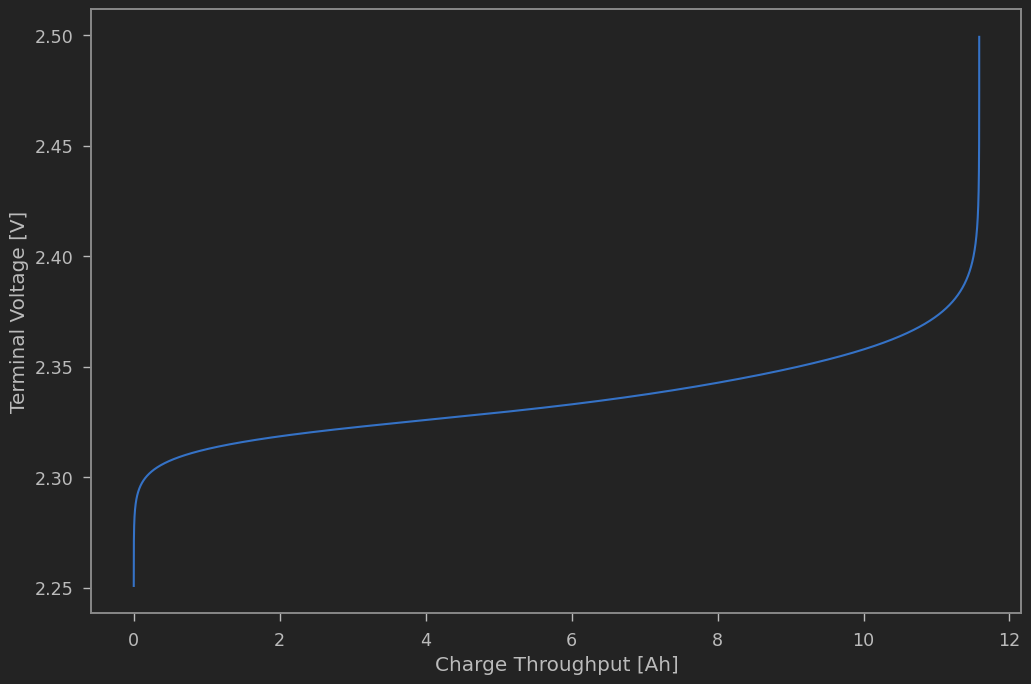

In [9]:
plt.plot(abs(current)*sim.solution.t/3600, voltage)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

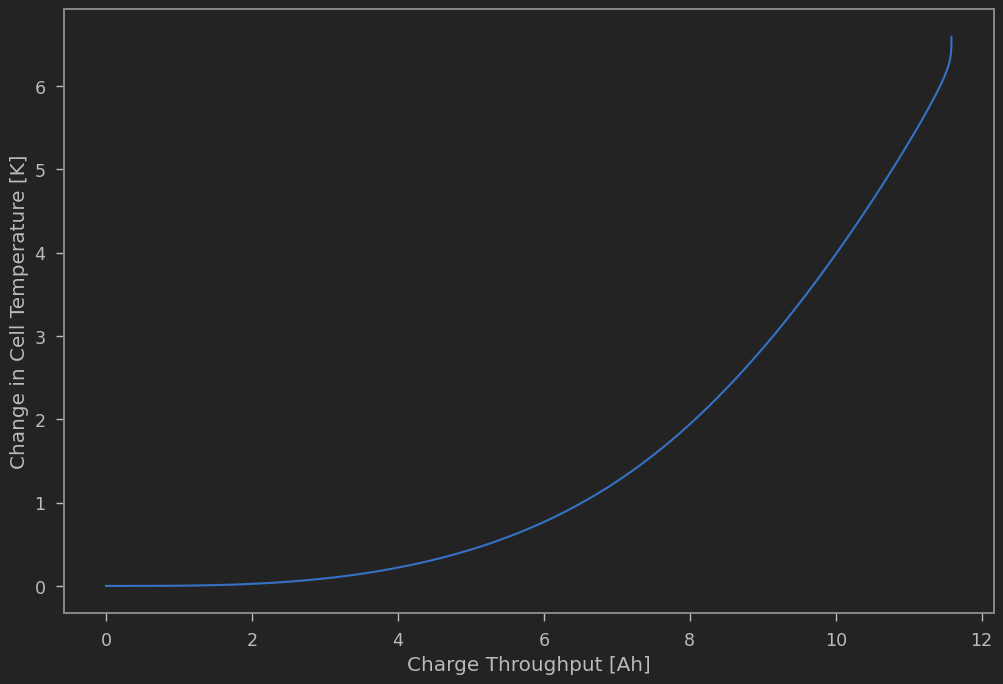

In [10]:
cell_temp = sim.solution["Cell Temperature [K]"].entries
plt.plot(abs(current)*sim.solution.t/3600, cell_temp-ref_temp)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Change in Cell Temperature [K]");

In [7]:
def Hua_charge_function(ref_temp):
    
    # get temperature
    print("Starting temperature %f" %(ref_temp))
    model = pybamm.lithium_sulfur.HuaEtAl2019()
    current = -1.0
    hours = 12
    time_in_seconds = hours*3600
    params = model.default_parameter_values
    params.update(
    {
    "Current function [A]": current,
    "Initial Condition for S8 ion [g]": S8_initial_charge,
    "Initial Condition for S4 ion [g]": S4_initial_charge,
    "Initial Condition for S2 ion [g]": S2_initial_charge,
    "Initial Condition for S ion [g]": S_initial_charge,
    "Initial Condition for Precipitated Sulfur [g]": Sp_initial_charge,
    "Initial Condition for Shuttled Sulfur [g]": 0.0,
    "Initial Condition for Terminal Voltage [V]": V_initial_charge,
    "Mass of active sulfur per cell [g]": 8.1,
    "Standard Potential L [V]": 2.195,
    "Exchange current density H [A.m-2]": 1,
    "Exchange current density L [A.m-2]": 0.5,
    "S saturation mass [g]": 5e-5,
    "Shuttle rate coefficient during charge [s-1]": 2.75e-5,
    "Reference Temperature [K]" : ref_temp
    }
    )

    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, 
            rtol=1e-3, 
            extra_options_setup={"max_step_size": 0.1}, 
            max_step_decrease_count = 15),
        )
    sim.solve(np.linspace(0, time_in_seconds, 100000))
    
    voltage = sim.solution['Terminal voltage [V]'].entries
    Ah = abs(current)*sim.solution.t/3600
    S8 = sim.solution["S8 [g]"].entries
    S4 = sim.solution["S4 [g]"].entries
    S2 = sim.solution["S2 [g]"].entries
    S1 = sim.solution["S [g]"].entries
    Sp = sim.solution["Precipitated Sulfur [g]"].entries
    Tc = sim.solution["Cell Temperature [K]"].entries

    return Ah, voltage, S8, S4, S2, S1, Sp, Tc

In [8]:
ref_temp_list = [298, 308, 318, 328, 338]
Hua_charge_data = Parallel(n_jobs=-1)(delayed(Hua_charge_function)(temp) for temp in ref_temp_list)

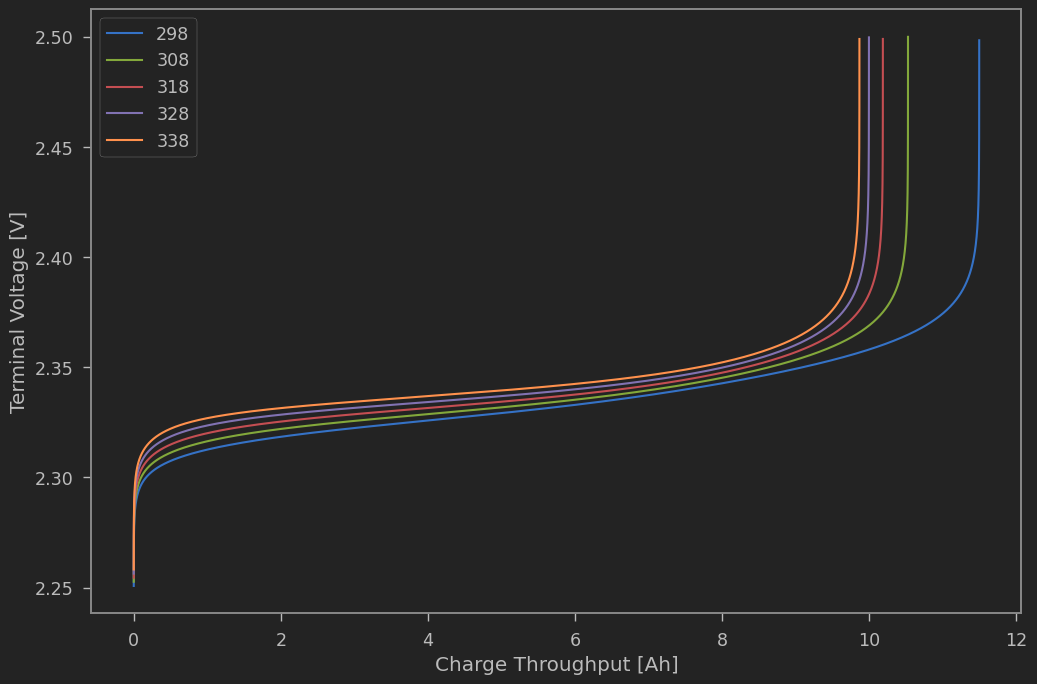

In [9]:
legend = []
i = 0
for subdata in Hua_charge_data:
    try:
        Ah = subdata[0]
        V = subdata[1]
        plt.plot(Ah, V)
        legend.append(ref_temp_list[i])
    except:
        pass
    i += 1
    
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]")
plt.legend(ref_temp_list)

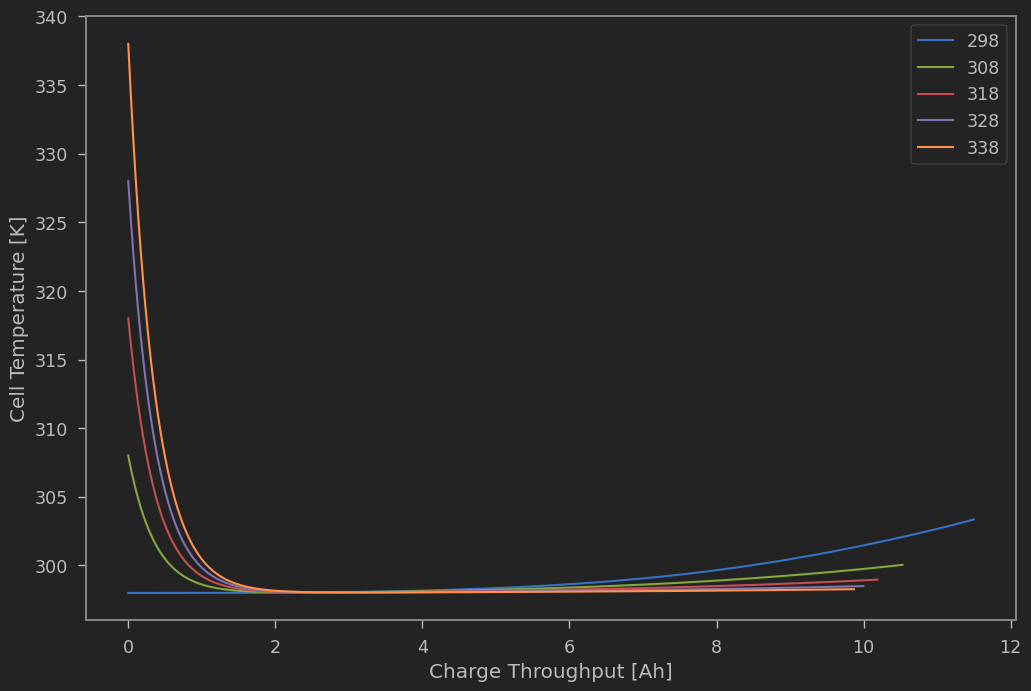

In [10]:
legend = []
i = 0
for subdata in Hua_charge_data:
    try:
        Ah = subdata[0]
        Tc = subdata[-1]
        plt.plot(Ah, Tc)
        legend.append(ref_temp_list[i])
    except:
        pass
    i += 1
    
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Cell Temperature [K]")
plt.legend(ref_temp_list)

In [11]:
Tc[0:15]

array([338.        , 337.98660689, 337.97321856, 337.9598347 ,
       337.94645533, 337.93308043, 337.91971002, 337.90634408,
       337.89298261, 337.87962562, 337.8662731 , 337.85292505,
       337.83958148, 337.82624236, 337.81290772])

In [15]:
Ah, voltage, S8, S4, S2, S1, Sp, Tc = Hua_charge_function(298)

Starting temperature 298.000000


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 41707.4 and h = 4.78283e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

AttributeError: 'ProcessedVariable' object has no attribute 'entires'

In [ ]:
Ah = subdata[0]
V = subdata[1]
plt.plot(Ah, V)